# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [ ]:
!nvidia-smi

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [ ]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import json
import optuna
import shutil
import pandas as pd
import torch

from ultralytics import YOLO
from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils, evaluation

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

Para entrenar un modelo propio de yolov10 con capas personalizadas procedemos de la siguiente forma:

In [3]:
selected_model = "custom"
yaml_path = f"yolo/yolo_models/{selected_model}.yaml"

model = YOLO(yaml_path)
print("Modelo OK")

Modelo OK


Entrenamiento con modelos de YOLO con pesos de COCO

In [4]:
selected_model = "custom" 
model_dir = "yolo/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")
# model_path = os.path.join(model_dir, f"{selected_model}.yaml")

if selected_model not in config.models:
    if(selected_model == "custom"):
        model = YOLO(f"{selected_model}.yaml")
    else:
        model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        if(selected_model == "custom"):
            shutil.move(f"{selected_model}.yaml", model_path)
        else:
            shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [5]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"
name_best_params = f"best_params_{selected_model}"

### **Optuna**

In [7]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED),  
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=10)
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-08-24 00:55:41,517] A new study created in RDB with name: custom_yolo10


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.9097990912717108, mosaic=0, mult

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 209.042.7 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_0\labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.00037207437472915983), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_0
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.16G      6.929      20.77      4.756        163        704: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      2.97G      6.864      8.494      4.729        154        704: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.02G      6.876       6.37      4.388        146        704: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35      3.03G      6.835      5.764       4.29        176        704: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/35      3.27G      6.802      5.044      4.113        168        704: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.22G      6.684      4.615      3.911        211        704: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.43it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35      3.06G      6.506      4.079      3.671        140        704: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35         3G      6.166      3.695      3.441        133        704: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.01G      5.687      3.094      3.205        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         75        878          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.14G      5.126      2.975      3.078        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         75        878    0.00287    0.00456     0.0031    0.00108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.12G      4.358      2.497      2.789        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         75        878      0.182     0.0364     0.0215    0.00541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35      3.05G      3.993      2.334      2.556        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         75        878      0.126     0.0649     0.0273    0.00678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35         3G      3.792      2.255      2.328        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         75        878      0.176     0.0979     0.0476     0.0103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35       3.1G      3.541      2.212      2.128        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


                   all         75        878      0.178      0.123     0.0604     0.0114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      3.02G      3.263      1.997      1.993        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

                   all         75        878      0.198      0.133     0.0688     0.0137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.01G      3.232       2.06       1.94         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.191      0.164     0.0817     0.0172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.06G      3.067      2.007      1.879        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         75        878      0.232      0.195      0.106     0.0221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35         3G      2.973      1.904      1.826         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         75        878       0.29      0.233      0.149     0.0344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35      2.99G      2.837       1.84      1.788        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         75        878      0.319      0.245      0.173     0.0442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.11G      2.774      1.865      1.742        190        704: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         75        878      0.329      0.248      0.173     0.0417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.21G      2.645      1.785      1.676        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         75        878      0.327      0.262      0.174     0.0419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.12G        2.6      1.753       1.59         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878      0.303      0.312      0.195      0.045

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35      3.08G      2.522      1.699       1.54         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         75        878      0.316       0.33      0.213     0.0505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.03G      2.468      1.676      1.502        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878       0.32      0.344      0.224     0.0534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35      3.07G      2.436       1.69      1.485        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878      0.327      0.331      0.215     0.0504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.19G      2.359      1.638      1.412        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.353      0.315      0.225     0.0523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      3.19G       2.33      1.627      1.405        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         75        878      0.362      0.346       0.24     0.0567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.21G      2.309      1.662      1.409        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.365      0.318      0.235     0.0551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35       3.1G      2.219      1.582      1.395        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         75        878       0.34      0.328      0.226     0.0511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      3.13G      2.227      1.619       1.37        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         75        878       0.33      0.329      0.219     0.0479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35      2.99G      2.226      1.575      1.363        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         75        878      0.337      0.326      0.227     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      3.04G      2.252      1.577      1.351        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         75        878      0.361      0.339       0.25     0.0564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      3.18G      2.201      1.555      1.355        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         75        878      0.372      0.351      0.259     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35      3.05G      2.218      1.613      1.344        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         75        878       0.37      0.363       0.27     0.0639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.19G      2.255      1.604      1.345        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.408      0.331       0.27     0.0652



35 epochs completed in 0.085 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_0\weights\last.pt, 12.3MB
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_0\weights\best.pt, 12.3MB

Validating runs\detect\optuna_trial_custom_yolo10_0\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom_YOLO10 summary (fused): 74 layers, 6,034,463 parameters, 0 gradients, 14.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


                   all         75        878      0.408       0.33       0.27     0.0651
Speed: 0.9ms preprocess, 6.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs\detect\optuna_trial_custom_yolo10_0


[I 2025-08-24 01:01:23,967] Trial 0 finished with value: 0.06514701677551074 and parameters: {'lr0': 0.0005611516415334506, 'lrf': 0.00892718030435363, 'momentum': 0.9097990912717108, 'weight_decay': 0.00039687933304443713, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 0 with value: 0.06514701677551074.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005399484409787433, lrf=0.003991305878561679, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.9062108866694067, mosaic=0, mult

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 202.144.6 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_1\labels.jpg... 
optimizer: SGD(lr=0.005399484409787433, momentum=0.9062108866694067) with parameter groups 59 weight(decay=0.0), 66 weight(decay=9.830050992369969e-05), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_1
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.23G      2.127      1.537       1.33        163        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         75        878      0.322      0.343      0.218     0.0473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      3.17G      2.093      1.619      1.312        154        704: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         75        878      0.206      0.249      0.108     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.04G      2.079      1.496      1.261        146        704: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         75        878      0.315      0.394       0.23     0.0563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35       3.1G      1.951       1.55      1.231        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         75        878      0.434      0.412      0.334     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/35      3.16G      1.976      1.457      1.212        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         75        878      0.377      0.391      0.269     0.0527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.24G      1.909      1.443      1.186        211        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         75        878      0.273      0.293      0.147      0.028

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35      3.07G      1.845      1.363      1.167        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         75        878      0.466       0.47       0.39     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.09G      1.842       1.41      1.154        133        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878      0.387      0.382      0.268     0.0535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.08G      1.696      1.359      1.094        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         75        878      0.512      0.507      0.447     0.0987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.15G      1.775      1.263      1.107        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         75        878      0.559      0.551      0.518      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.11G      1.633      1.241      1.068        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.468      0.514      0.388     0.0767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35      3.08G      1.572      1.265      1.053        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         75        878      0.663      0.719      0.703      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      3.01G      1.557      1.137      1.045        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         75        878      0.599      0.645      0.564      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      3.13G      1.528      1.124      1.027        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         75        878      0.621      0.662        0.6      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      3.04G      1.464      1.125      1.024        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         75        878      0.493      0.546      0.369      0.066

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.03G      1.472      1.124      1.025         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         75        878      0.672      0.681      0.661      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.13G      1.519      1.122      1.027        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         75        878      0.701      0.711       0.71      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.04G      1.453      1.153       1.01         61        704: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         75        878      0.616      0.662      0.587      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35      3.05G      1.372      1.035     0.9926        172        704: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         75        878      0.257      0.294      0.113     0.0166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.18G      1.413      1.053     0.9994        190        704: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         75        878      0.468      0.479      0.337     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.22G      1.338      1.016     0.9886        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         75        878       0.51      0.519      0.378     0.0619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.07G      1.412      1.072     0.9981         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.738      0.756      0.774      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      3.09G      1.373       1.02     0.9822         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878      0.771      0.773      0.812      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      3.03G      1.354      1.054     0.9824        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         75        878      0.537      0.538      0.406     0.0669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35      3.07G      1.344      1.005     0.9843        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         75        878      0.764      0.756      0.785      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.19G      1.329      1.028     0.9682        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         75        878      0.725      0.782      0.781      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      3.18G       1.29       1.02     0.9662        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         75        878      0.493      0.534      0.381     0.0608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35       3.2G      1.344      1.031     0.9795        161        704: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         75        878      0.709      0.732      0.716      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35       3.1G      1.261      1.004     0.9695        170        704: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.577      0.586      0.472     0.0771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      3.07G      1.295       1.01     0.9732        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         75        878      0.719      0.754      0.741      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35      2.97G      1.299      1.002     0.9716        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         75        878      0.726      0.716      0.701      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.06G      1.324     0.9795     0.9672        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         75        878      0.755      0.777      0.797      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      3.02G      1.292     0.9827     0.9624        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         75        878      0.713      0.722      0.703      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35         3G      1.348      1.017     0.9719        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         75        878      0.761      0.781      0.798      0.221

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.19G      1.331      1.011     0.9663        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         75        878      0.783       0.77      0.808      0.238



35 epochs completed in 0.088 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_1\weights\last.pt, 12.3MB


[I 2025-08-24 01:07:24,800] Trial 1 finished with value: 0.23832446727827944 and parameters: {'lr0': 0.005399484409787433, 'lrf': 0.003991305878561679, 'momentum': 0.9062108866694067, 'weight_decay': 0.00010485387725194633, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 1 with value: 0.23832446727827944.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002310201887845295, lrf=0.0015254729458052604, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8456363364439307, mosaic=0, mu

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 621.4103.2 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_2\labels.jpg... 
optimizer: AdamW(lr=0.0002310201887845295, momentum=0.8456363364439307) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.0003138540289233688), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_2
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.24G      1.273      1.027     0.9627        163        704: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         75        878      0.764      0.784      0.803      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      3.21G      1.309      1.088      0.968        154        704: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         75        878      0.632      0.623      0.552     0.0939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.09G      1.331      1.009     0.9577        146        704: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         75        878      0.776      0.787      0.821      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35      3.12G      1.312      1.023     0.9569        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         75        878      0.597      0.623      0.489      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/35      3.13G      1.282     0.9965      0.951        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         75        878      0.763      0.748      0.752       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.28G      1.227     0.9741     0.9466        211        704: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         75        878      0.693      0.683      0.644      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35       3.1G      1.262     0.9826     0.9506        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         75        878      0.709      0.713      0.675      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.12G      1.302      1.007     0.9567        133        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         75        878      0.643      0.644      0.561       0.09

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.11G      1.245      0.953     0.9401        145        704: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         75        878      0.784      0.806       0.84      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.18G      1.306      1.035     0.9519        224        704: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         75        878      0.729      0.737      0.726      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.16G      1.235     0.9755     0.9381        176        704: 100%|██████████| 20/20 [00:08<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878      0.711      0.737      0.692      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35      3.14G      1.295      0.983     0.9527        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878       0.77      0.804      0.811      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      2.98G      1.198     0.9349     0.9333        143        704: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]

                   all         75        878      0.758      0.776      0.777      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      3.17G      1.233     0.9349     0.9367        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         75        878      0.763       0.78      0.784      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      3.07G        1.2     0.9325     0.9351        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         75        878      0.702      0.734      0.678      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      3.12G      1.206     0.9339     0.9424         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         75        878      0.588       0.59      0.472     0.0705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.17G      1.283     0.9528     0.9501        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         75        878       0.79      0.788      0.822      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.22G      1.259     0.9537     0.9396         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         75        878      0.767      0.777      0.778      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35      3.02G      1.186     0.9208     0.9304        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         75        878      0.722      0.735      0.704      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.15G      1.248     0.9246      0.944        190        704: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         75        878      0.769      0.767      0.773      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.18G      1.173      0.896     0.9326        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.626      0.645      0.536     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.08G      1.257     0.9256     0.9405         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.775      0.793       0.79      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35      3.08G      1.198     0.9087     0.9274         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.779       0.79      0.789      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.04G       1.22     0.9242     0.9328        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.744      0.741       0.73      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      3.06G      1.216     0.9317     0.9421        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         75        878      0.671      0.673      0.601      0.101

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.18G      1.224     0.9294     0.9329        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         75        878      0.801      0.817      0.846      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      3.16G      1.201      0.917     0.9302        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.776       0.78      0.798      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.22G      1.242     0.9499     0.9442        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         75        878       0.72      0.729      0.691      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35      3.12G      1.179     0.9215     0.9359        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878      0.749      0.762      0.747      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      3.17G      1.193       0.92     0.9394        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         75        878      0.704      0.722      0.675      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      3.11G      1.228     0.9233     0.9406        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.744      0.759      0.741      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.22G      1.253     0.9142     0.9399        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.767      0.787      0.791      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35       3.2G      1.217      0.915     0.9353        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         75        878      0.763      0.779      0.777      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35      3.22G      1.276     0.9521     0.9449        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         75        878      0.764      0.778      0.778      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35       3.2G      1.275     0.9466     0.9446        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         75        878      0.771      0.781      0.784      0.188



35 epochs completed in 0.089 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_2\weights\last.pt, 12.3MB


[I 2025-08-24 01:13:19,874] Trial 2 finished with value: 0.18752003492834268 and parameters: {'lr0': 0.0002310201887845295, 'lrf': 0.0015254729458052604, 'momentum': 0.8456363364439307, 'weight_decay': 0.0003347776308515934, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 1 with value: 0.23832446727827944.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8549542764940538, mosaic=0, mu

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 138.331.9 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_3\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.0002679422874194002), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_3
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.37G      1.168     0.9045     0.9316        163        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.742      0.775      0.758      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      3.18G      1.216     0.9323     0.9414        154        704: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878       0.72      0.751       0.71      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.08G      1.267     0.9303     0.9379        146        704: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         75        878      0.757      0.793      0.783      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35      3.06G      1.225     0.9354     0.9327        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         75        878      0.789      0.804       0.82      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      3.12G        1.2     0.9243     0.9281        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         75        878       0.76      0.775      0.777       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      3.21G      1.148     0.8998     0.9263        211        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         75        878      0.727      0.747      0.714      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35      3.09G      1.182     0.9072     0.9294        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.732      0.753      0.725      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.05G      1.235     0.9209     0.9383        133        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         75        878      0.755      0.751      0.754      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.21G       1.17     0.8928     0.9196        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         75        878      0.758      0.774      0.771      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.16G      1.244     0.9266     0.9377        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878      0.767      0.787      0.785      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.21G      1.183     0.8968     0.9231        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.769      0.787      0.784       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35      3.11G      1.238     0.9217     0.9368        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         75        878      0.758      0.768      0.762      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      2.96G      1.152     0.8785     0.9207        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         75        878      0.768      0.784      0.788      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      3.17G      1.179     0.8897      0.922        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         75        878      0.765      0.781      0.784       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      3.06G      1.138     0.8881     0.9217        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         75        878       0.75      0.764      0.755      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.23G      1.161     0.8829     0.9299         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         75        878      0.712      0.737      0.693      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.19G      1.237      0.911     0.9386        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         75        878      0.742      0.764      0.737      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.22G      1.214      0.913     0.9288         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         75        878      0.773      0.795      0.797      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35         3G      1.145     0.8743     0.9188        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.772       0.79      0.795      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.19G      1.204     0.8843     0.9337        190        704: 100%|██████████| 20/20 [00:08<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         75        878      0.755      0.774      0.769       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.23G      1.142     0.8679     0.9247        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878      0.726      0.751      0.715      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.08G      1.213     0.8877     0.9301         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         75        878      0.741      0.746      0.725       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35       3.1G      1.165     0.8766     0.9204         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         75        878      0.737      0.753      0.725      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.04G       1.19     0.8897     0.9254        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         75        878      0.761      0.765      0.764      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35      3.08G      1.188     0.8871     0.9324        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         75        878      0.755       0.77      0.758       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.23G      1.194     0.8883     0.9242        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         75        878      0.768      0.786      0.782      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      3.19G      1.172     0.8871     0.9227        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.775      0.785      0.785      0.184

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.21G      1.218     0.9163     0.9366        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]

                   all         75        878      0.764      0.773      0.773      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35      3.11G      1.166     0.8906     0.9307        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         75        878      0.756      0.762       0.75      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      3.17G      1.177     0.8915     0.9342        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878       0.75      0.755      0.737      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35       3.1G       1.21     0.9047      0.935        122        704: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

                   all         75        878      0.745      0.754      0.731      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.05G      1.241     0.9025     0.9351        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         75        878      0.752      0.769      0.748       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      3.14G      1.205     0.8986     0.9311        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.758      0.763      0.757      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      3.01G      1.277     0.9366     0.9424        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         75        878      0.762      0.767      0.767      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.17G      1.279     0.9314     0.9431        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.763      0.771      0.773      0.171



35 epochs completed in 0.087 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_3\weights\last.pt, 12.3MB


[I 2025-08-24 01:19:13,283] Trial 3 finished with value: 0.17095795964712449 and parameters: {'lr0': 0.00019010245319870352, 'lrf': 0.001959497205867916, 'momentum': 0.8549542764940538, 'weight_decay': 0.0002858051065806936, 'optimizer': 'SGD', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 1 with value: 0.23832446727827944.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015304852121831463, lrf=0.001112885317490573, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8911317277852158, mosaic=0, mul

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 119.729.2 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_4\labels.jpg... 
optimizer: AdamW(lr=0.0015304852121831463, momentum=0.8911317277852158) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.00013883386049976746), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_4
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.25G      1.254      1.063      0.943        163        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         75        878      0.432      0.444      0.288     0.0419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      3.14G      1.307      1.028     0.9548        154        704: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878     0.0634     0.0923    0.00983    0.00155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.07G      1.331      1.011     0.9469        146        704: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878      0.731      0.738      0.759      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35      3.13G      1.315      1.021     0.9435        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         75        878      0.754      0.778      0.794      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/35      3.19G      1.297      1.023     0.9418        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.619      0.637      0.566     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.26G      1.263      1.005     0.9398        211        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         75        878      0.669      0.664      0.625      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35       3.1G      1.274     0.9739     0.9387        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         75        878      0.752      0.719      0.725      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.04G      1.324     0.9949     0.9478        133        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         75        878      0.732      0.735      0.709      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.05G      1.237     0.9616     0.9235        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         75        878      0.829       0.82      0.871      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.18G      1.292      1.003     0.9365        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         75        878      0.704      0.733      0.691      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.17G      1.225     0.9433     0.9237        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]

                   all         75        878      0.624      0.573      0.492     0.0694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      3.13G      1.249     0.9633     0.9332        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         75        878      0.808       0.82      0.849      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      3.04G      1.181     0.9031     0.9166        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878       0.78      0.784      0.785      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      3.14G      1.196     0.9244     0.9113        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878      0.703      0.727      0.683      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      3.05G      1.121     0.8788     0.9078        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         75        878      0.619      0.677      0.583      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.05G      1.077     0.8159     0.9059         86        704: 100%|██████████| 20/20 [00:08<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         75        878       0.52      0.438      0.428      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35       3.1G      1.092     0.8732     0.9027        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         75        878      0.697      0.688      0.698      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.04G      1.054     0.8498     0.8955         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         75        878      0.619      0.688      0.568       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35         3G      1.026     0.8193     0.8903        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

                   all         75        878      0.587      0.622      0.491       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      3.22G      1.079     0.8039     0.9028        190        704: 100%|██████████| 20/20 [00:08<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878      0.737      0.718      0.702      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.17G      1.027     0.7765     0.8927        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         75        878      0.721      0.757      0.707       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.08G       1.02     0.7705     0.8894         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         75        878      0.717      0.743      0.685      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35       3.1G      1.003     0.7413     0.8839         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

                   all         75        878      0.819      0.813      0.852      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.04G      1.013     0.7485     0.8871        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         75        878       0.69      0.708      0.611      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35      3.08G      1.034     0.7458      0.894        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.826      0.827      0.878      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.19G       1.04     0.7446     0.8861        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

                   all         75        878      0.797      0.789      0.813      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35       3.2G     0.9569     0.7366     0.8794        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         75        878       0.84      0.829      0.885      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.22G     0.9553      0.733     0.8848        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.821       0.82      0.882      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35      3.12G     0.9357     0.7098     0.8839        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         75        878       0.81      0.829      0.868      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      3.08G     0.9519     0.7164     0.8876        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         75        878      0.811      0.816      0.875      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35       3.1G     0.9478      0.711     0.8807        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         75        878      0.824      0.827       0.88      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.05G     0.9274     0.6921      0.877        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

                   all         75        878      0.826      0.831      0.886      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      3.14G     0.9097     0.6986     0.8779        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         75        878      0.819      0.835       0.88      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      3.21G     0.9551     0.7054     0.8807        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         75        878      0.824      0.836      0.886       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.22G     0.9268     0.6939     0.8778        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         75        878      0.831      0.827      0.888      0.583



35 epochs completed in 0.086 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_4\weights\last.pt, 12.3MB
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_4\weights\best.pt, 12.3MB

Validating runs\detect\optuna_trial_custom_yolo10_4\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom_YOLO10 summary (fused): 74 layers, 6,034,463 parameters, 0 gradients, 14.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


                   all         75        878      0.831      0.827      0.888      0.583
Speed: 0.4ms preprocess, 6.8ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\detect\optuna_trial_custom_yolo10_4


[I 2025-08-24 01:25:10,105] Trial 4 finished with value: 0.5829056483415752 and parameters: {'lr0': 0.0015304852121831463, 'lrf': 0.001112885317490573, 'momentum': 0.8911317277852158, 'weight_decay': 0.00014808945119975197, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 4 with value: 0.5829056483415752.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.004138040112561018, lrf=0.0020165721691808598, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8146508171009577, mosaic=0, mul

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 592.071.1 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_5\labels.jpg... 
optimizer: AdamW(lr=0.004138040112561018, momentum=0.8146508171009577) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.0004531106842957937), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_5
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.26G      1.074     0.7821     0.8981        163        704: 100%|██████████| 20/20 [00:08<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         75        878       0.76      0.797      0.776      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/35      3.16G      1.097     0.8755     0.9011        154        704: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.828      0.811      0.876      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/35      3.09G      1.227     0.9088      0.919        146        704: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         75        878      0.728      0.747       0.75      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/35      3.08G      1.283     0.9753      0.926        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         75        878      0.571      0.327      0.391      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/35      3.14G      1.295     0.9899     0.9236        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         75        878      0.637      0.587      0.586      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.16G      1.313     0.9145     0.9377        211        704: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         75        878      0.795      0.722      0.794      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/35      3.12G       1.28     0.9162     0.9316        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.828      0.764      0.844      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.06G      1.168     0.9127     0.9124        133        704: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         75        878      0.613      0.642      0.518      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.07G      1.114     0.8313     0.8987        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

                   all         75        878      0.807       0.77      0.838      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35       3.2G      1.233      0.848      0.921        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         75        878      0.736      0.722      0.692      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.19G      1.182     0.8771     0.9106        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         75        878      0.469      0.391      0.372      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/35       3.1G      1.142     0.9002      0.903        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

                   all         75        878      0.841      0.758      0.862       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      3.12G       1.12     0.7941     0.8997        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         75        878      0.767      0.776      0.789      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35      3.16G      1.044     0.7815     0.8869        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         75        878      0.818      0.756      0.806      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      3.07G      1.148     0.8005     0.9027        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.742      0.757      0.733      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.06G      1.028     0.7564     0.8906         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         75        878      0.746      0.731      0.722      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.12G      1.025     0.7631     0.8892        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         75        878      0.769       0.77      0.787      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.05G      1.015     0.7543     0.8825         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878      0.735      0.733      0.691      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/35      3.01G      1.005     0.7395     0.8779        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all         75        878      0.763      0.749      0.738      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.24G     0.9629     0.7067     0.8761        190        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]

                   all         75        878      0.802      0.824      0.833       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.18G     0.9817      0.717     0.8804        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         75        878      0.745      0.763      0.728      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35       3.1G      1.007     0.7471     0.8788         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         75        878      0.792      0.801       0.82      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35      3.12G     0.9381     0.7123     0.8683         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         75        878      0.835      0.811      0.876      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.05G     0.9411     0.6874     0.8684        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         75        878      0.816      0.784      0.826      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/35       3.1G     0.9231     0.6745     0.8719        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

                   all         75        878      0.835      0.812      0.875      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.21G     0.9342     0.6698     0.8657        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         75        878      0.804      0.761      0.806      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      3.21G     0.9197     0.6679     0.8691        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.765      0.797      0.785      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.23G     0.9099     0.6676     0.8694        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         75        878       0.82      0.813      0.861        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/35      3.13G     0.8878     0.6601     0.8671        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         75        878      0.807      0.796      0.833       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35       3.1G     0.8881     0.6575     0.8704        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         75        878      0.825      0.819      0.892      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35         3G     0.8789     0.6484     0.8607        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]

                   all         75        878      0.841      0.807      0.894      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.07G      0.885     0.6411     0.8614        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         75        878      0.837      0.835      0.895      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      3.16G     0.8554     0.6388     0.8616        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         75        878      0.818      0.815      0.861      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35      3.22G      0.877     0.6372     0.8627        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         75        878      0.818      0.818      0.858      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.24G     0.8637     0.6332     0.8608        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         75        878      0.831      0.808      0.867      0.527



35 epochs completed in 0.086 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_5\weights\last.pt, 12.3MB


[I 2025-08-24 01:30:51,896] Trial 5 finished with value: 0.5271977212400298 and parameters: {'lr0': 0.004138040112561018, 'lrf': 0.0020165721691808598, 'momentum': 0.8146508171009577, 'weight_decay': 0.0004833180632488466, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 4 with value: 0.5829056483415752.


New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00011715937392307068, lrf=0.008115595675970505, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8388169972400026, mosaic=0, mu

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 630.3139.8 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_custom_yolo10_6\labels.jpg... 
optimizer: AdamW(lr=0.00011715937392307068, momentum=0.8388169972400026) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.00043101616731864055), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_custom_yolo10_6
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.26G     0.8655     0.6684     0.8608        163        704: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         75        878      0.829      0.812      0.871      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      3.15G     0.8407     0.6476     0.8586        154        704: 100%|██████████| 20/20 [00:06<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all         75        878      0.818      0.809      0.853      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      3.09G     0.8575     0.6352     0.8558        146        704: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

                   all         75        878       0.84      0.828      0.893      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      3.07G     0.8576     0.6382     0.8517        176        704: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         75        878      0.835      0.842      0.897      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      3.19G     0.8385     0.6218     0.8562        168        704: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]

                   all         75        878      0.834      0.837       0.89      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/35      3.16G     0.8172     0.6176     0.8561        211        704: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]

                   all         75        878      0.832      0.839      0.893      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      3.11G     0.8227     0.6302     0.8556        140        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         75        878      0.846      0.836      0.893      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/35      3.01G     0.8349     0.6201     0.8556        133        704: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878      0.845      0.839        0.9      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/35      3.14G     0.8429     0.6158      0.852        145        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]

                   all         75        878      0.851      0.831      0.895      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/35      3.19G       0.84     0.6187     0.8533        224        704: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         75        878      0.836      0.842      0.894      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/35      3.17G     0.8265      0.611     0.8527        176        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         75        878      0.835      0.844      0.897      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35       3.1G      0.857     0.6343     0.8586        137        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878      0.836      0.849      0.896      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/35      3.05G     0.8202     0.6149     0.8525        143        704: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         75        878      0.837      0.844      0.895      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/35       3.1G     0.8192     0.6078     0.8504        157        704: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         75        878      0.834      0.834      0.883      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/35      3.08G     0.8209     0.6201     0.8509        144        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]

                   all         75        878      0.838      0.835      0.892       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/35      3.17G     0.8286     0.6073     0.8591         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]

                   all         75        878      0.842      0.833      0.892      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/35      3.19G     0.8286     0.6113     0.8532        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         75        878      0.837      0.826      0.884      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/35      3.24G     0.8321     0.6163     0.8533         61        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.843      0.824      0.893      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35       3.1G     0.8184     0.6093     0.8504        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.841      0.826      0.886      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/35      3.24G     0.8198     0.6048      0.852        190        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         75        878      0.833      0.836       0.89      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/35      3.18G     0.8259     0.6054     0.8561        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         75        878      0.841      0.835      0.889      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/35      3.08G     0.8053     0.6065     0.8499         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         75        878      0.833      0.833      0.885      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/35      3.08G     0.8095     0.6032     0.8459         80        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878      0.835      0.839       0.89      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/35      3.05G     0.8029     0.6123     0.8479        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.835      0.841      0.892       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35       3.1G     0.8031        0.6     0.8519        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878      0.832       0.84      0.887       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/35      3.21G     0.8087     0.6013     0.8505        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         75        878      0.828      0.831      0.879      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/35      3.21G     0.8131     0.6067     0.8503        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         75        878       0.83      0.836      0.884      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/35      3.23G     0.8114     0.6107     0.8537        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878      0.829      0.836      0.885      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      3.13G     0.7975     0.6026     0.8533        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

                   all         75        878      0.828      0.836      0.884      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/35      3.18G     0.8105     0.6044     0.8577        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         75        878      0.829      0.836      0.886      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/35      3.04G     0.8064     0.6047     0.8504        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

                   all         75        878      0.832      0.839       0.89      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/35      3.09G     0.8205     0.6019     0.8527        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         75        878      0.832      0.838      0.889       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/35      3.23G     0.8135      0.604     0.8541        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

                   all         75        878      0.833      0.838      0.893      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/35       3.1G     0.8375     0.6143      0.856        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         75        878      0.834      0.839      0.894      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/35      3.23G     0.8406     0.6165     0.8563        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


                   all         75        878      0.834      0.839      0.894       0.54

35 epochs completed in 0.086 hours.
Optimizer stripped from runs\detect\optuna_trial_custom_yolo10_6\weights\last.pt, 12.3MB


[I 2025-08-24 01:36:38,030] Trial 6 finished with value: 0.5403488894763101 and parameters: {'lr0': 0.00011715937392307068, 'lrf': 0.008115595675970505, 'momentum': 0.8388169972400026, 'weight_decay': 0.0004597505784732166, 'optimizer': 'AdamW', 'warmup_epochs': 5, 'warmup_momentum': 0.75, 'degrees': 45, 'translate': 0.1, 'scale': 0.06, 'flipud': 0.5, 'fliplr': 0.5, 'mosaic': 0, 'close_mosaic': 0}. Best is trial 4 with value: 0.5829056483415752.


Número de trials completados: 7


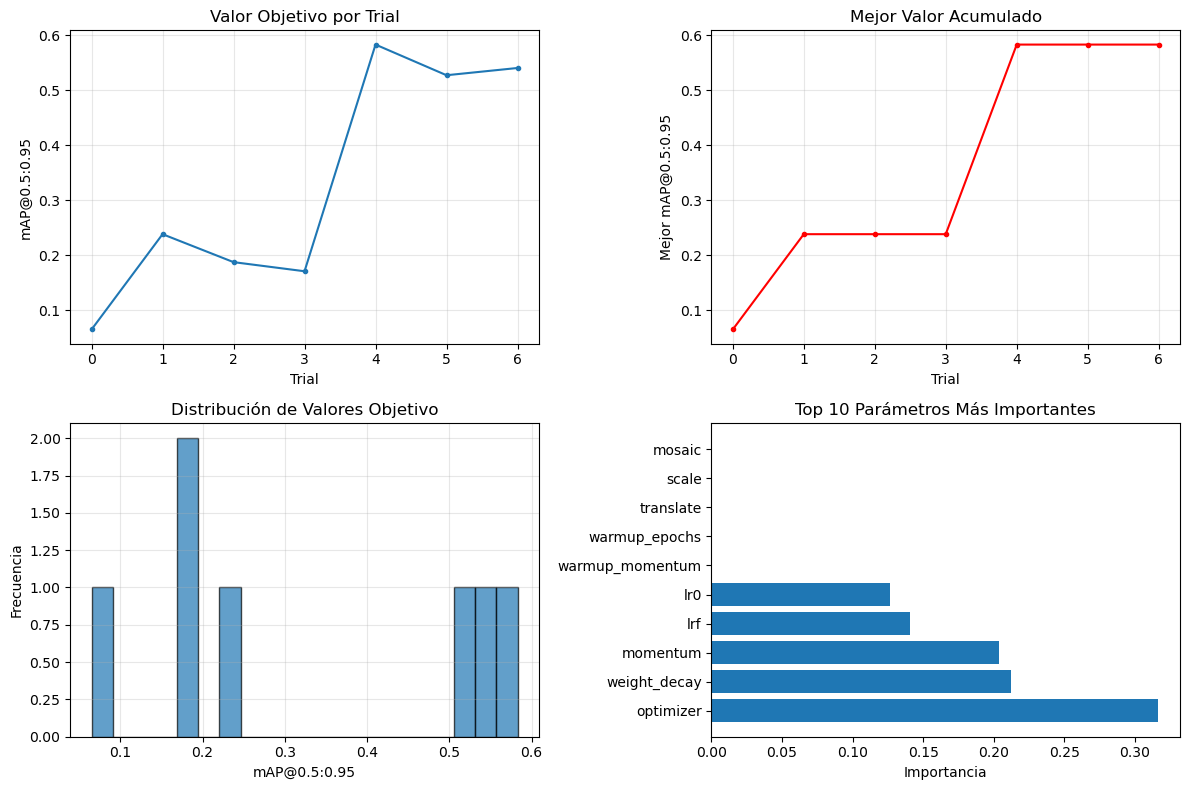

In [8]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [9]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.0015304852121831463
  lrf: 0.001112885317490573
  momentum: 0.8911317277852158
  weight_decay: 0.00014808945119975197
  optimizer: AdamW
  warmup_epochs: 5
  warmup_momentum: 0.75
  degrees: 45
  translate: 0.1
  scale: 0.06
  flipud: 0.5
  fliplr: 0.5
  mosaic: 0
  close_mosaic: 0


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [ ]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)

In [ ]:
kfold_utils.save_results(metrics_df, model_output_kfold)

In [ ]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [ ]:
# params = getattr(config, name_best_params)
params = best_params

model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,  
    seed=config.SEED,       
    **params
)

New https://pypi.org/project/ultralytics/8.3.184 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=15, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0015304852121831463, lrf=0.001112885317490573, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo/yolo_models/custom_yolo10.yaml, momentum=0.8911317277852158, mosaic=0, mul

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 298 images, 18 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 132.511.8 MB/s, size: 85.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 75 images, 5 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_custom_yolo10\labels.jpg... 
optimizer: AdamW(lr=0.0015304852121831463, momentum=0.8911317277852158) with parameter groups 59 weight(decay=0.0), 66 weight(decay=0.00013883386049976746), 65 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_custom_yolo10
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      3.27G     0.8697     0.6733     0.8608        163        704: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

                   all         75        878      0.776      0.815      0.794      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      3.19G     0.8508     0.6677     0.8578        154        704: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


                   all         75        878      0.767      0.818      0.796      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      3.12G     0.9042     0.6637     0.8595        146        704: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         75        878      0.812      0.823      0.865      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      3.05G     0.8889       0.66     0.8549        176        704: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         75        878      0.845      0.787      0.871      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      3.16G     0.8767     0.6457     0.8579        168        704: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

                   all         75        878      0.834      0.808      0.881       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      3.17G     0.8738     0.6482      0.861        211        704: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         75        878       0.81      0.843       0.89      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      3.12G     0.8743     0.6693     0.8609        140        704: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         75        878      0.851      0.815      0.884      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      3.14G     0.8988     0.6469     0.8593        133        704: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         75        878      0.814      0.823      0.859       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      3.12G     0.9042     0.6533     0.8556        145        704: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878       0.85      0.841      0.902      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40       3.2G     0.9006     0.6581     0.8575        224        704: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.823      0.852      0.897      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      3.18G      0.909     0.6599       0.86        176        704: 100%|██████████| 20/20 [00:06<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


                   all         75        878      0.812      0.824      0.868      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      3.07G     0.8938     0.6688     0.8597        137        704: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         75        878      0.847      0.845      0.904      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      3.07G     0.8549     0.6421     0.8547        143        704: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.835      0.856      0.892      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      3.09G     0.8567     0.6283     0.8515        157        704: 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         75        878      0.828       0.83      0.866      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      3.09G     0.8539     0.6345     0.8526        144        704: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         75        878      0.826      0.851      0.896      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      3.24G     0.8732     0.6235     0.8632         86        704: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         75        878      0.816      0.879      0.895       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      3.21G     0.8554     0.6327     0.8531        235        704: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         75        878       0.81       0.87      0.897      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      3.25G     0.8453     0.6268     0.8519         61        704: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

                   all         75        878      0.813      0.806       0.85      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      3.03G     0.8498     0.6235     0.8526        172        704: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]

                   all         75        878      0.847      0.804       0.87      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      3.25G     0.8561     0.6243     0.8551        190        704: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.52it/s]

                   all         75        878      0.846       0.83      0.896      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40       3.2G     0.8598     0.6156     0.8564        174        704: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         75        878      0.848      0.836      0.902      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      3.12G     0.8303     0.6269     0.8486         88        704: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


                   all         75        878      0.819      0.853      0.893        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      3.09G     0.8279     0.6073     0.8463         80        704: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         75        878       0.81      0.877      0.906      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       3.1G     0.8273     0.6187      0.846        197        704: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

                   all         75        878      0.811      0.862      0.899      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      3.12G     0.8319     0.6135     0.8506        220        704: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         75        878      0.845      0.832      0.899      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      3.25G     0.8361      0.613     0.8491        120        704: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.844      0.844      0.905      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      3.23G     0.8192     0.6032     0.8474        247        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.827      0.847      0.901      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      3.27G     0.8233     0.6083     0.8527        161        704: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.825      0.856      0.903      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      3.17G      0.802     0.5987     0.8506        170        704: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         75        878      0.838      0.847      0.899      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      3.12G     0.8147     0.5976     0.8558        173        704: 100%|██████████| 20/20 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.853      0.833      0.905      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      3.09G     0.8127     0.5967     0.8478        122        704: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         75        878      0.846      0.829      0.896      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      3.16G     0.8124     0.5939     0.8485        152        704: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         75        878      0.834      0.841      0.895      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      3.23G     0.8022     0.5965     0.8489        228        704: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         75        878       0.83      0.847      0.897      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      3.21G     0.8398     0.6013     0.8532        119        704: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         75        878      0.817      0.857      0.894      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      3.25G      0.819     0.6012     0.8495        215        704: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]

                   all         75        878      0.833      0.849        0.9      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      3.19G     0.8243      0.601     0.8482        155        704: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]

                   all         75        878      0.832      0.844      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      3.08G     0.8365     0.6029     0.8447        125        704: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]

                   all         75        878      0.835      0.842      0.902      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      3.07G     0.8111     0.5906     0.8517        185        704: 100%|██████████| 20/20 [00:07<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         75        878      0.835      0.846      0.906       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      3.19G     0.8051     0.5832     0.8495         74        704: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         75        878      0.838      0.841      0.904      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      3.09G     0.8081     0.5906     0.8489        262        704: 100%|██████████| 20/20 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         75        878      0.839      0.841      0.906      0.567



40 epochs completed in 0.098 hours.
Optimizer stripped from runs\detect\final_model_custom_yolo10\weights\last.pt, 12.3MB
Optimizer stripped from runs\detect\final_model_custom_yolo10\weights\best.pt, 12.3MB

Validating runs\detect\final_model_custom_yolo10\weights\best.pt...
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom_YOLO10 summary (fused): 74 layers, 6,034,463 parameters, 0 gradients, 14.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


                   all         75        878      0.853      0.833      0.905      0.616
Speed: 0.4ms preprocess, 7.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs\detect\final_model_custom_yolo10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024F6DA88A10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

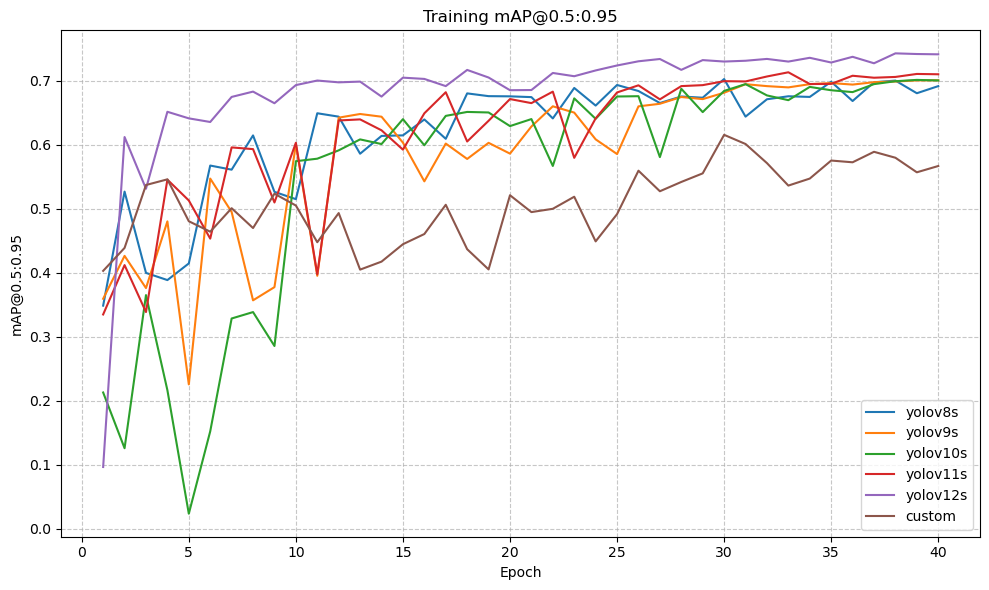

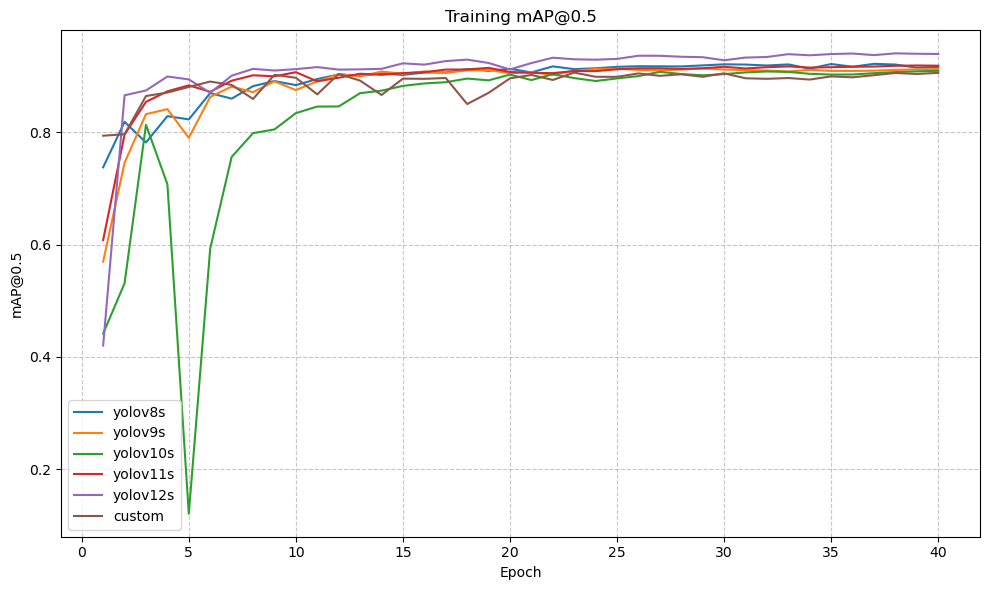

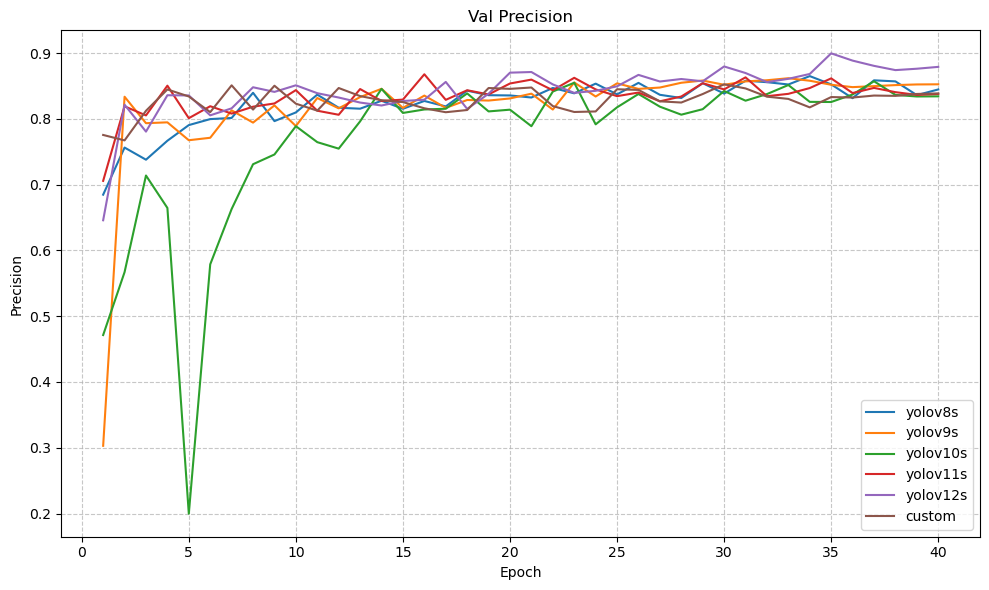

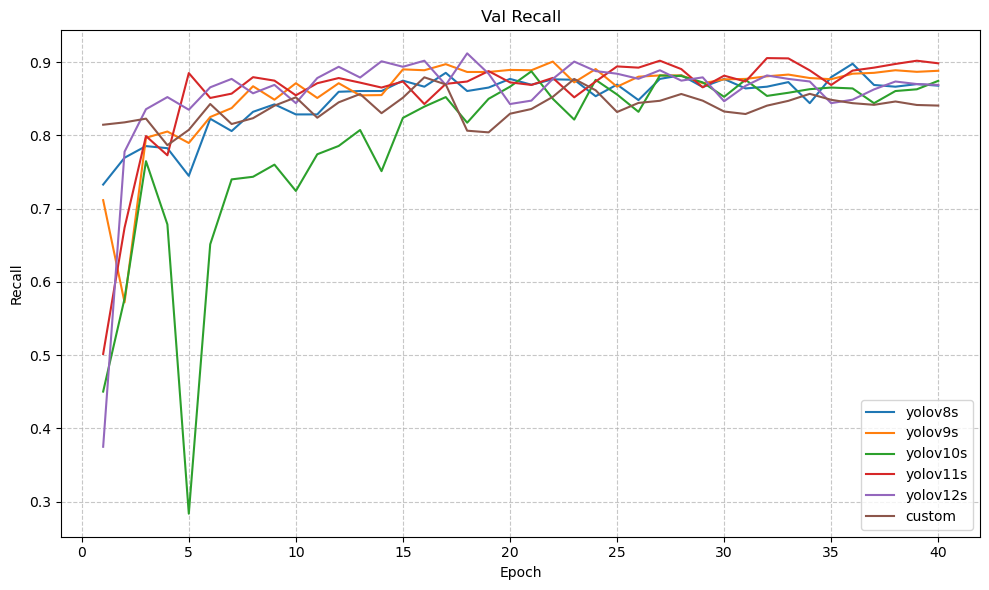

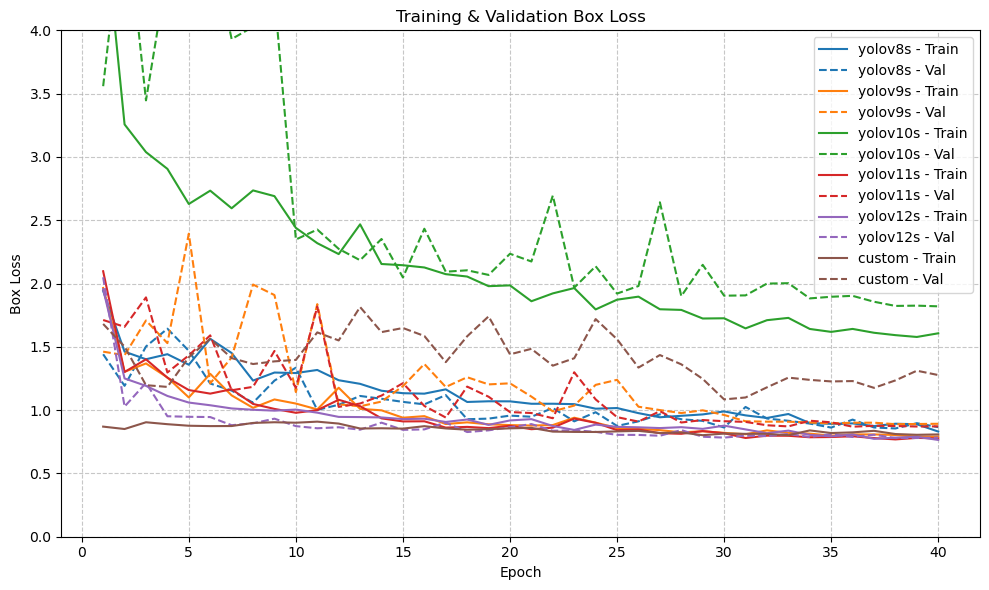

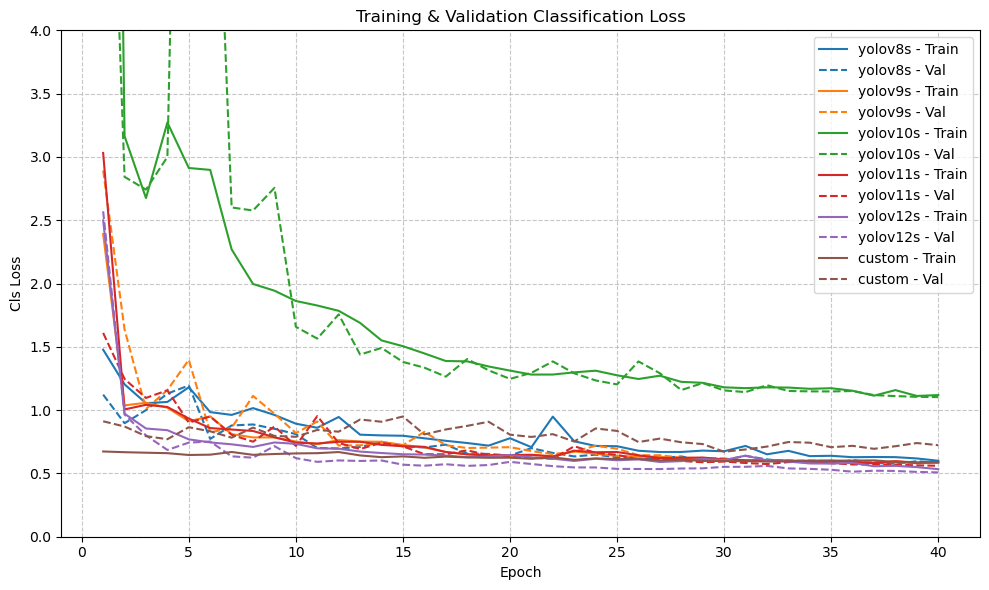

In [3]:
plots_dir = 'yolo/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluación**

In [4]:
tests = ["test_original"]
results = evaluation.evaluate_models(tests=tests)

Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.40.1 ms, read: 9.66.2 MB/s, size: 67.5 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<00:00, 489.53it/s]

val: New cache created: ..\03.Datasets\YOLO_Datasets\test_original\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


                   all         94       1273      0.843      0.844       0.92      0.722
Speed: 2.2ms preprocess, 11.5ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs\detect\eval_yolov8s_test_original3
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 657.1251.0 MB/s, size: 71.4 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all         94       1273      0.838      0.852      0.921      0.721
Speed: 2.9ms preprocess, 15.2ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\detect\eval_yolov9s_test_original
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 698.5142.6 MB/s, size: 97.7 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all         94       1273      0.821      0.867      0.918      0.717
Speed: 2.5ms preprocess, 12.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\eval_yolov10s_test_original
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 668.9310.3 MB/s, size: 88.0 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]


                   all         94       1273      0.861      0.824      0.921      0.732
Speed: 2.2ms preprocess, 11.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs\detect\eval_yolov11s_test_original
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 845.9163.0 MB/s, size: 108.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]


                   all         94       1273      0.856      0.863      0.936      0.761
Speed: 2.0ms preprocess, 20.2ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\eval_yolov12s_test_original
Ultralytics 8.3.177  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
custom_YOLO10 summary (fused): 74 layers, 6,034,463 parameters, 0 gradients, 14.8 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 574.2142.7 MB/s, size: 102.2 KB)


val: Scanning ..\03.Datasets\YOLO_Datasets\test_original\labels.cache... 94 images, 7 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


                   all         94       1273      0.845      0.814      0.892       0.62
Speed: 2.7ms preprocess, 8.7ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs\detect\eval_custom_test_original


In [5]:
# RESULTADOS CUANDO SE CARGARON LAS ANOTACIONES DE TEST ORIGINAL
df = pd.DataFrame(results)
display(df[df["Test"] == "test_original"])

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Time_s,Inferencia_ms
0,yolov8s,test_original,0.843,0.844,0.920,0.722,10.092,11.452
1,yolov9s,test_original,0.838,0.852,0.921,0.721,9.550,15.174
2,yolov10s,test_original,0.821,0.867,0.918,0.717,9.183,12.220
3,yolov11s,test_original,0.861,0.824,0.921,0.732,9.594,11.463
4,yolov12s,test_original,0.856,0.863,0.936,0.761,10.831,20.192
5,custom,test_original,0.845,0.814,0.892,0.620,9.986,8.656


In [4]:
df = pd.DataFrame(results)
display(df)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95,Time_s,Inferencia_ms
0,yolov8s,test,0.855,0.838,0.926,0.704,28.608,10.788
1,yolov9s,test,0.851,0.876,0.933,0.706,25.355,13.310
2,yolov10s,test,0.853,0.861,0.927,0.701,25.711,10.773
3,yolov11s,test,0.846,0.866,0.930,0.716,24.295,10.068
4,yolov12s,test,0.861,0.848,0.936,0.740,23.235,14.485
5,custom,test,0.836,0.853,0.903,0.607,24.612,8.626
6,yolov8s,test2,0.924,0.938,0.969,0.553,7.152,22.272
7,yolov9s,test2,0.917,0.927,0.961,0.542,7.317,20.555
8,yolov10s,test2,0.956,0.898,0.962,0.589,7.126,15.716
9,yolov11s,test2,0.929,0.917,0.964,0.534,7.087,13.173


## ENSEMBLE

In [4]:
# === Ensemble: Concat+NMS y Weighted Boxes Fusion (WBF) y evaluación en test, test2, test3 ===
# Requiere: pip install ensemble-boxes (solo para WBF)
# %pip install ensemble-boxes

import os, math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from ultralytics import YOLO

try:
    from ensemble_boxes import weighted_boxes_fusion
    HAS_WBF = True
except ImportError:
    HAS_WBF = False
    print("Instala ensemble-boxes para WBF: pip install ensemble-boxes")

# Modelos base seleccionados para el ensemble
ensemble_model_paths = {
    "yolov12s": config.final_model_path["yolov12s"],
    "yolov11s": config.final_model_path["yolov11s"],
    "yolov10s":  config.final_model_path["yolov8s"],
}

base_models = {k: YOLO(p) for k,p in ensemble_model_paths.items()}

# Pesos (puedes ajustarlos usando mAP@0.5:0.95 de validación)
model_weights = {
    "yolov12s": 0.8,
    "yolov11s": 0.4,
    "yolov10s":  0.75
}

# Utilidades
def load_yolo_labels(label_file):
    boxes = []
    if not os.path.exists(label_file):
        return np.zeros((0,5), dtype=float)
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=float) if boxes else np.zeros((0,5), dtype=float)

def yolo_to_xyxy_norm(boxes):
    # boxes: (N,5) cls, cx, cy, w, h (normalizado)
    if boxes.size == 0:
        return boxes[:, :0]
    cx, cy, w, h = boxes[:,1], boxes[:,2], boxes[:,3], boxes[:,4]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return np.stack([x1,y1,x2,y2], axis=1)

def xyxy_to_yolo_norm(xyxy):
    # xyxy normalizado -> (cx,cy,w,h)
    if xyxy.size == 0:
        return xyxy[:, :0]
    x1,y1,x2,y2 = xyxy[:,0], xyxy[:,1], xyxy[:,2], xyxy[:,3]
    w = x2 - x1
    h = y2 - y1
    cx = x1 + w/2
    cy = y1 + h/2
    return np.stack([cx,cy,w,h], axis=1)

def iou_matrix(a, b):
    # a,b: (N,4) (M,4) en formato xyxy normalizado
    if a.size == 0 or b.size == 0:
        return np.zeros((len(a), len(b)), dtype=float)
    ious = np.zeros((len(a), len(b)), dtype=float)
    for i, box_a in enumerate(a):
        ax1, ay1, ax2, ay2 = box_a
        aarea = max(0, ax2-ax1) * max(0, ay2-ay1)
        for j, box_b in enumerate(b):
            bx1, by1, bx2, by2 = box_b
            barea = max(0, bx2-bx1) * max(0, by2-by1)
            ix1 = max(ax1, bx1)
            iy1 = max(ay1, by1)
            ix2 = min(ax2, bx2)
            iy2 = min(ay2, by2)
            iw = max(0, ix2-ix1)
            ih = max(0, iy2-iy1)
            inter = iw * ih
            union = aarea + barea - inter
            ious[i,j] = inter / union if union > 0 else 0.0
    return ious

def soft_nms(boxes, scores, iou_thr=0.9, sigma=0.9, score_thr=0.9):
    # boxes: (N,4), scores: (N,)
    boxes = boxes.copy()
    scores = scores.copy()
    N = boxes.shape[0]
    keep = []
    for i in range(N):
        maxscore = scores[i]
        maxpos = i

        # Get max score box
        for j in range(i+1, N):
            if scores[j] > maxscore:
                maxscore = scores[j]
                maxpos = j
        # Swap
        boxes[i], boxes[maxpos] = boxes[maxpos].copy(), boxes[i].copy()
        scores[i], scores[maxpos] = scores[maxpos], scores[i]

        boxA = boxes[i]
        for j in range(i+1, N):
            boxB = boxes[j]
            # IoU
            xx1 = max(boxA[0], boxB[0])
            yy1 = max(boxA[1], boxB[1])
            xx2 = min(boxA[2], boxB[2])
            yy2 = min(boxA[3], boxB[3])
            w = max(0.0, xx2 - xx1)
            h = max(0.0, yy2 - yy1)
            inter = w * h
            areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
            areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
            iou = inter / (areaA + areaB - inter) if (areaA + areaB - inter) > 0 else 0.0

            # Soft-NMS
            if iou > iou_thr:
                scores[j] *= np.exp(- (iou ** 2) / sigma)
        if scores[i] > score_thr:
            keep.append(i)
    return np.array(keep)

def nms_concat(pred_lists, iou_thr=0.9, conf_thr=0.9, use_soft_nms=True):
    # pred_lists: lista de dicts con keys: boxes (xyxy norm), conf, cls
    if not pred_lists:
        return np.zeros((0,6))
    all_boxes = []
    for p in pred_lists:
        boxes = p["boxes"]
        scores = p["conf"]
        cls = p["cls"]
        arr = np.concatenate([boxes, scores[:,None], cls[:,None]], axis=1)
        all_boxes.append(arr)
    dets = np.concatenate(all_boxes, axis=0)
    dets = dets[dets[:,4] >= conf_thr]
    if dets.shape[0] == 0:
        return dets
    keep_final = []
    for c in np.unique(dets[:,5]):
        dc = dets[dets[:,5]==c]
        if use_soft_nms:
            idx = soft_nms(dc[:,:4], dc[:,4], iou_thr=iou_thr, sigma=0.5, score_thr=conf_thr)
        else:
            tboxes = torch.tensor(dc[:,:4])
            tscores = torch.tensor(dc[:,4])
            idx = torch.ops.torchvision.nms(tboxes, tscores, iou_thr).numpy()
        keep_final.append(dc[idx])
    return np.concatenate(keep_final, axis=0) if keep_final else np.zeros((0,6))

def predict_single_model(model, image_path, imgsz):
    r = model.predict(image_path, imgsz=imgsz, conf=0.001, verbose=False)[0]
    h, w = r.orig_shape
    if r.boxes.shape[0] == 0:
        return {"boxes": np.zeros((0,4)), "conf": np.zeros((0,)), "cls": np.zeros((0,))}
    xyxy = r.boxes.xyxy.cpu().numpy()
    conf = r.boxes.conf.cpu().numpy()
    cls = r.boxes.cls.cpu().numpy()
    # Normalizar
    xyxy_norm = xyxy.copy()
    xyxy_norm[:,[0,2]] /= w
    xyxy_norm[:,[1,3]] /= h
    return {"boxes": xyxy_norm, "conf": conf, "cls": cls}

def ensemble_concat_nms(image_path, imgsz=704, iou_thr=0.90, conf_thr=0.9):
    plist = [predict_single_model(m, image_path, imgsz) for m in base_models.values()]
    dets = nms_concat(plist, iou_thr=iou_thr, conf_thr=conf_thr)
    return dets  # (N,6) xyxy + conf + cls (normalizado)

def ensemble_wbf(image_path, imgsz=704, iou_thr=0.9, skip_box_thr=0.5):
    if not HAS_WBF:
        return np.zeros((0,6))
    boxes_list, scores_list, labels_list, weights = [], [], [], []
    shapes = None
    for name, m in base_models.items():
        r = predict_single_model(m, image_path, imgsz)
        boxes_list.append(r["boxes"].tolist())
        scores_list.append(r["conf"].tolist())
        labels_list.append(r["cls"].astype(int).tolist())
        weights.append(model_weights[name])
    if sum(len(b) for b in boxes_list) == 0:
        return np.zeros((0,6))
    fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes_list, scores_list, labels_list,
        weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr
    )
    fused_boxes = np.array(fused_boxes)
    fused_scores = np.array(fused_scores)
    fused_labels = np.array(fused_labels)
    return np.concatenate([fused_boxes, fused_scores[:,None], fused_labels[:,None]], axis=1)

# Métricas (AP@0.5 y AP@[0.5:0.95], precisión y recall global)
def compute_metrics(preds_all, gts_all, iou_thresholds=None):
    # preds_all & gts_all: listas por imagen
    if iou_thresholds is None:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
    # Para precisión/recall global a IoU=0.5 (primera)
    iou_main = iou_thresholds[0]
    tp_main = 0
    fp_main = 0
    fn_main = 0

    # AP por IoU
    APs = []
    for t in iou_thresholds:
        scores = []
        matches = []
        total_gts = 0
        # Recolectar predicciones (1 clase)
        all_pred_entries = []
        for preds, gts in zip(preds_all, gts_all):
            # gts: (M,4) xyxy norm
            total_gts += gts.shape[0]
            if preds.shape[0] == 0:
                continue
            # Ordenar por score
            order = np.argsort(-preds[:,4])
            p = preds[order]
            matched = np.zeros(gts.shape[0], dtype=bool)
            for row in p:
                box_p = row[:4][None,:]
                ious = iou_matrix(box_p, gts)
                best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                best_iou = ious[0,best_i] if gts.shape[0] else 0
                is_tp = best_iou >= t and (best_i >=0) and (not matched[best_i])
                if is_tp:
                    matched[best_i] = True
                all_pred_entries.append((row[4], 1 if is_tp else 0))
            # fin imagen
        if total_gts == 0:
            APs.append(0.0)
            continue
        if not all_pred_entries:
            APs.append(0.0)
            continue
        all_pred_entries.sort(key=lambda x: -x[0])
        cum_tp = 0
        cum_fp = 0
        precisions = []
        recalls = []
        for sc, is_tp in all_pred_entries:
            if is_tp:
                cum_tp += 1
            else:
                cum_fp += 1
            precisions.append(cum_tp / (cum_tp + cum_fp))
            recalls.append(cum_tp / total_gts)
        # AP (interp 11 pts estilo voc o integración)
        # Usamos integración trapezoidal sobre recall ordenado
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        # Asegurar monotonicidad descendente
        for i in range(len(precisions)-2, -1, -1):
            precisions[i] = max(precisions[i], precisions[i+1])
        # Puntos únicos en recall
        unique_recalls, idx = np.unique(recalls, return_index=True)
        ap = np.trapz(precisions[idx], unique_recalls)
        APs.append(ap)

        if math.isclose(t, iou_main):
            # Compute global precision/recall at main IoU (usar mismos matches)
            # Repetimos conteo
            total_gts_main = 0
            tp_m = 0
            fp_m = 0
            for preds, gts in zip(preds_all, gts_all):
                total_gts_main += gts.shape[0]
                if preds.shape[0] == 0:
                    continue
                order = np.argsort(-preds[:,4])
                p = preds[order]
                matched = np.zeros(gts.shape[0], dtype=bool)
                for row in p:
                    box_p = row[:4][None,:]
                    ious = iou_matrix(box_p, gts)
                    best_i = np.argmax(ious[0]) if gts.shape[0] else -1
                    best_iou = ious[0,best_i] if gts.shape[0] else 0
                    if best_iou >= iou_main and best_i >=0 and (not matched[best_i]):
                        matched[best_i] = True
                        tp_m += 1
                    else:
                        fp_m += 1
            fn_m = total_gts_main - tp_m
            tp_main, fp_main, fn_main = tp_m, fp_m, fn_m

    mp = tp_main / (tp_main + fp_main) if (tp_main + fp_main) > 0 else 0.0
    mr = tp_main / (tp_main + fn_main) if (tp_main + fn_main) > 0 else 0.0
    map50 = APs[0] if len(APs) > 0 else 0.0
    map5095 = float(np.mean(APs)) if APs else 0.0
    return {
        "mp": mp,
        "mr": mr,
        "map50": map50,
        "map": map5095
    }

def get_split_image_label_dirs(split_name):
    base = Path("..") / "03.Datasets" / "YOLO_Datasets"
    images = base / split_name / "images"
    labels = base / split_name / "labels"
    return images, labels

def evaluate_ensemble(split, method="concat_nms", imgsz=config.IMGSZ):
    img_dir, label_dir = get_split_image_label_dirs(split)
    image_paths = [p for p in img_dir.iterdir() if p.suffix.lower() in [".jpg", ".png", ".jpeg"]]
    preds_all = []
    gts_all = []
    for img_path in image_paths:
        # Ground truth
        gt_label = (label_dir / (img_path.stem + ".txt"))
        gts_raw = load_yolo_labels(str(gt_label))  # cls, cx, cy, w, h
        gts_xyxy = yolo_to_xyxy_norm(gts_raw) if gts_raw.size else np.zeros((0,4))
        gts_all.append(gts_xyxy)

        if method == "concat_nms":
            dets = ensemble_concat_nms(str(img_path), imgsz=imgsz, iou_thr=0.60, conf_thr=0.2)
        elif method == "wbf":
            dets = ensemble_wbf(str(img_path), imgsz=imgsz, iou_thr=0.50, skip_box_thr=0.3)
        else:
            dets = np.zeros((0,6))

        # dets: (N,6) xyxy + conf + cls
        preds_all.append(dets if dets.size else np.zeros((0,6)))
    metrics = compute_metrics(preds_all, gts_all)
    return metrics

test_splits = ["test","test2","test3"]
ensemble_results = []
for split in test_splits:
    # m1 = evaluate_ensemble(split, method="concat_nms")
    # ensemble_results.append({
    #     "Modelo": "ensemble_concat_nms",
    #     "Test": split,
    #     "Precisión": m1["mp"],
    #     "Recall": m1["mr"],
    #     "mAP@0.5": m1["map50"],
    #     "mAP@0.5:0.95": m1["map"]
    # })
    m2 = evaluate_ensemble(split, method="wbf")
    ensemble_results.append({
        "Modelo": "ensemble_wbf",
        "Test": split,
        "Precisión": m2["mp"],
        "Recall": m2["mr"],
        "mAP@0.5": m2["map50"],
        "mAP@0.5:0.95": m2["map"]
    })

df_ensemble = pd.DataFrame(ensemble_results)
display(df_ensemble)

,Modelo,Test,Precisión,Recall,mAP@0.5,mAP@0.5:0.95
0,ensemble_wbf,test,0.840589,0.888810,0.866627,0.687113
1,ensemble_wbf,test2,0.895425,0.951389,0.938807,0.490459
2,ensemble_wbf,test3,0.833198,0.906608,0.884262,0.702570


Quitar los map no sirven en esta comparativa pero usar la amtriz de confusión

| Imagen            | Test      | yolov8s 0.5 | yolov8s 0.7 | yolov9s 0.5 | yolov9s 0.7 | yolov10s 0.5 | yolov10s 0.7 | yolov11s 0.5 | yolov11s 0.7 | yolov12s 0.5 | yolov12s 0.7 |
|-------------------|:---------:|:-----------:|:-----------:|:-----------:|:-----------:|:------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| 59 imagen         |     1     |      ❌    |      ✅     |     ❌      |     ✅      |     ❌      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| 61 imagen         |     1     |      ❌    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| 219 imagen        |     1     |      ❌    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| 369 imagen        |     1     |      ✅    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| already tested-00 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-15 |     3     |      ✅    |      ✅     |     ❌      |     ❌      |     ✅      |     ✅      |     ❌       |     ✅      |     ✅       |     ✅      |
| already tested-16 |     3     |      ✅    |      ✅     |     ❌      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-17 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ✅      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |
| already tested-22 |     3     |      ✅    |      ✅     |     ✅      |     ✅      |     ❌      |     ✅      |     ✅       |     ✅      |     ✅       |     ✅      |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file

comentar en la memoria el uso de linters como ruff